# Analysis: Divided Attention Experiment 




----
## Stimuli

![Stimuli](../figures/fig_stimuli.png)

### Blocked trial types
|         | **Simultaneous** | **Sequential** |
| ----:   | ---- | ---- |
| **Catch**   | 50 trials   | 50 trials  |
| **No Catch** | 200 trials  | 200 trials |


### Timing

|Simultaneous | Frame 1 | ?-frame             | ??-frame           |
| ----        | ----    | -----               |----                |
|             |  100 ms | Subject terminated  | Subject terminated |


| Sequential  | Frame 1   | (Blank) |  Frame 2 | ?-frame            | ??-frame           |
| ----        | ----      | ----    | -----    | -----              |----                |
|             |   50 ms   | 800 ms  | 50 ms    | Subject terminated | Subject terminated |

### Quest input parameters

```
tGuess      = log10(12);    % log of estimated threshold -  time for peripheral accuracy
tGuessSd    = log10(3);     % standard deviation
pThreshold  = 0.75;         % performance will converage at this
beta        = 3.5;          % steepness of the Weibull function, typically 3
delta       = 0.01;         % fraction of trials observer presses blindly
gamma       = 0.5;          % fraction of trials generate response 1 when intensity = -inf
```

### Instructions

In this experiment, you will be presented with a set of numbers and letters on a screen, and then will be asked to report which letters you saw. 

During each trial, you will first be presented with a fixation dot in the middle of the screen. This fixation dot marks the beginning of a single trial. Then a set of letters and numbers will briefly appear and then disappear. Afterwards, you'll see a question mark appear prompting you to report via the keyboard which letters appeared on the screen. Once you've reported the letters, the trial will end and the next one will begin.

On some set of trials, you will see 4 characters appear simultaneously on the screen (2 letters + 2 numbers). On another set of trials, 2 characters (1 letter + 1 number) will appear, then will disappear, followed by another pair of characters.


### Task
Your task in this experiment is to **report which 2 letters appeared in single trial** via the keyboard. 

- When you see 1 question mark, enter in one of the letters you saw. 
- When you see 2 question marks, enter in the other letter you saw. 
- Order does not matter. 

Throughout the trial, the brightness of the colors will change. Even if you have a hard time seeing the letters, **make your best guess** as to which 2 letters appeared. Typically, at the start the letters will be hard to see, so don't worry if you have to make a guess. 

<br>
<br>
<br>






In [1]:
import pandas as pd
import os, glob

data_dir       = "../data"
data_filenames = glob.glob(os.path.join(data_dir,'*.csv'))
raw_df         = pd.DataFrame()
list_          = []
subj_df        = pd.DataFrame()

for data_file in data_filenames:
    subj_file = os.path.join(data_dir,data_file)
    subj_df   = pd.read_csv(subj_file, index_col=None, header=0)
    list_.append(subj_df)

raw_df = pd.concat(list_)  

## Clean data
- Drop unnecessary variables/columns
- Remove header rows
- Convert string data to numerics

In [2]:
# Delete unused columns/variables
raw_df.head()
df = raw_df.drop(['save_filename', 'font_rgb_color', 'Unnamed: 18'], axis=1)

In [3]:
# Filter out rows with a copy of the header-row info
df = df[df.date != 'date'] 

In [4]:
# Convert strings to ints
def transform_feature( df, column_name ):
    
    def label_map(y):
        return int(y)
    
    df[column_name] = df[column_name].apply( label_map )
    return df

### list of column names indicating which columns to transform; 
### this is just a start!  Use some of the print( labels_df.head() )
### output upstream to help you decide which columns get the
### transformation
names_of_columns_to_transform = ['trial_order_num']
for column in names_of_columns_to_transform:
    df = transform_feature( df, column )
    

In [5]:
# Convert strings to floats
def transform_str2float(df, column_name):
    def label_map(y):
        return float(y)
    
    df[column_name] = df[column_name].apply(label_map)
    return df

columns_to_transform = ['ITI'
                       , 'response01_time'
                       , 'response02_time'
                       , 'luminance_contrast']

for column in columns_to_transform:
    df = transform_str2float(df, column)
    

#### Example data

In [6]:
df.head()

,date,start_time,expt_id,subj_id,trial_order_num,trial_type,catch_type,ITI,char_stim,response01_key,response01_time,response01_acc,response02_key,response02_time,response02_acc,luminance_contrast
0,11/16/2015,3:02:35 PM,scz_seq_sim_divided_attn,A01,1,simultaneous,catch,0.55192,BC68,B,1.7997,TRUE,C,0.29767,TRUE,100
1,11/16/2015,3:02:35 PM,scz_seq_sim_divided_attn,A01,2,simultaneous,catch,0.58198,3MA1,A,1.1384,TRUE,N,0.16582,FALSE,100
2,11/16/2015,3:02:35 PM,scz_seq_sim_divided_attn,A01,3,simultaneous,catch,0.66170,F16B,B,1.3420,TRUE,F,0.14302,TRUE,100
3,11/16/2015,3:02:35 PM,scz_seq_sim_divided_attn,A01,4,simultaneous,catch,0.67347,9XD8,D,1.0902,TRUE,X,0.16395,TRUE,100
4,11/16/2015,3:02:35 PM,scz_seq_sim_divided_attn,A01,5,simultaneous,catch,0.64735,76YN,Y,1.1065,TRUE,N,1.18140,TRUE,100


## Group data into conditions: Simultaneous vs Sequential

In [7]:
# Find last trial number for each of the groups
max_sim_trials = df[ (df.trial_type      == 'simultaneous') 
                   & (df.catch_type      == 'no_catch')].trial_order_num.max()

max_seq_trials = df[ (df.trial_type      == 'simultaneous') 
                   & (df.catch_type      == 'no_catch')].trial_order_num.max()

# ----------
sim_trial_df = df[ (df.trial_type      == 'simultaneous')
                 & (df.catch_type      == 'no_catch')
                 & (df.trial_order_num == max_sim_trials)]
seq_trial_df = df[ (df.trial_type      == 'sequential')
                 & (df.catch_type      == 'no_catch')
                 & (df.trial_order_num == max_seq_trials)]


## Remove Outliers: Greater than 2 standard deviations in luminance contrast

In [8]:
num_stdevs        = 2

seq_stdevs_cutoff = seq_trial_df.luminance_contrast.std() * 2
seq_trial_df      = seq_trial_df[seq_trial_df.luminance_contrast < seq_stdevs_cutoff]

sim_stdevs_cutoff = sim_trial_df.luminance_contrast.std() * 2
sim_trial_df      = sim_trial_df[sim_trial_df.luminance_contrast < sim_stdevs_cutoff]



In [9]:
sim_trial_df.describe()

,trial_order_num,ITI,response01_time,response02_time,luminance_contrast
count,39,39.000000,39.000000,39.000000,39.000000
mean,200,0.600205,1.296781,0.314485,23.631800
std,0,0.024639,0.351259,0.227900,32.674151
min,200,0.551120,0.649830,0.028601,10.767500
25%,200,0.609350,1.081050,0.123075,12.806550
50%,200,0.609350,1.277600,0.250120,15.076000
75%,200,0.609350,1.421100,0.434645,21.081950
max,200,0.660300,2.182500,0.902820,202.174500


In [10]:
seq_trial_df.describe()

,trial_order_num,ITI,response01_time,response02_time,luminance_contrast
count,39,39.000000,39.000000,39.000000,39.000000
mean,200,0.563831,1.874201,0.421508,17.271149
std,0,0.008412,2.469109,0.451358,7.361781
min,200,0.527510,0.316820,0.021083,11.795500
25%,200,0.561970,1.144950,0.140035,13.591550
50%,200,0.561970,1.362600,0.246210,14.643700
75%,200,0.561970,1.612050,0.494585,17.484150
max,200,0.577260,14.591000,1.914600,45.819000


## Histogram: Luminance Contrasts for Sequential Trials

In [11]:
%matplotlib inline
import matplotlib
from pylab import rcParams

matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 10, 7

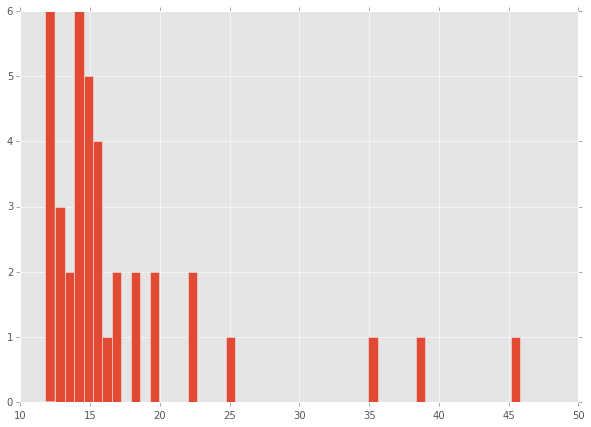

In [12]:
seq_trial_df.luminance_contrast.hist(bins=50)

In [13]:
seq_trial_df.luminance_contrast.describe()

count    39.000000
mean     17.271149
std       7.361781
min      11.795500
25%      13.591550
50%      14.643700
75%      17.484150
max      45.819000
Name: luminance_contrast, dtype: float64

## Histogram: Luminance contrasts for Simultaneous trials

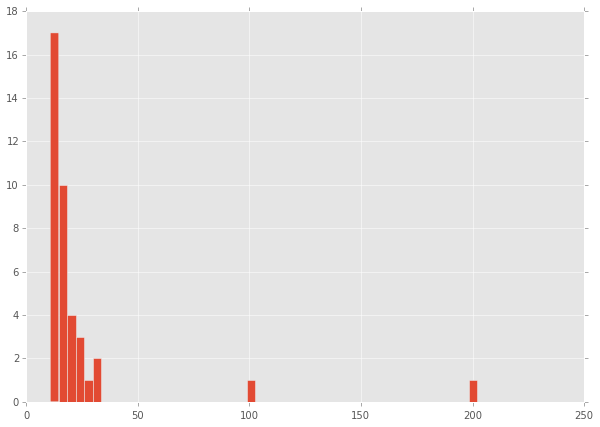

In [14]:
sim_trial_df.luminance_contrast.hist(bins=50)

In [15]:
sim_trial_df.luminance_contrast.describe()

count     39.000000
mean      23.631800
std       32.674151
min       10.767500
25%       12.806550
50%       15.076000
75%       21.081950
max      202.174500
Name: luminance_contrast, dtype: float64

## Final luminance contrast difference between conditions

Luminance contrast difference: 
- **Simultaneous - Sequential
 = 23.631800 - 17.271149 = 6.360651**


In [16]:
'%f - %f = %f' %(  sim_trial_df.luminance_contrast.mean()
                 , seq_trial_df.luminance_contrast.mean()
                 , sim_trial_df.luminance_contrast.mean()-seq_trial_df.luminance_contrast.mean())



'23.631800 - 17.271149 = 6.360651'

## 2-tailed T-test between conditions: final luminance contrasts
- **t = -1.18598  p = 0.242321**

In [17]:
import numpy as np
from scipy.stats   import ttest_ind
from scipy.special import stdtr

# Set input data
a = seq_trial_df.luminance_contrast
b = sim_trial_df.luminance_contrast

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(a, b, equal_var=False)
"ttest_ind: t = %g  p = %g" %(t, p)



'ttest_ind: t = -1.18598  p = 0.242321'

-----

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context({'figure.figsize': (15, 7)})

## Plot: Luminance Contrasts - All Subjects

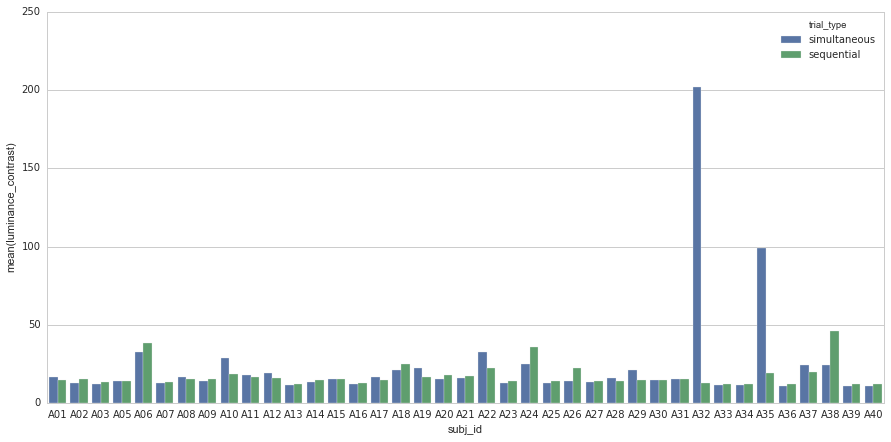

In [20]:
subjs_df = df[ (df.catch_type      == 'no_catch')
             & (df.trial_order_num == max_sim_trials)]

cutoff = subjs_df.luminance_contrast.std() * 2
subjs_df = subjs_df[subjs_df.luminance_contrast < cutoff]

plt_sim = sns.barplot(x='subj_id', y='luminance_contrast'
                      , hue='trial_type'
                      , data=subjs_df)

## Plot: Zoomed in Individual Subjects

[(0, 50)]

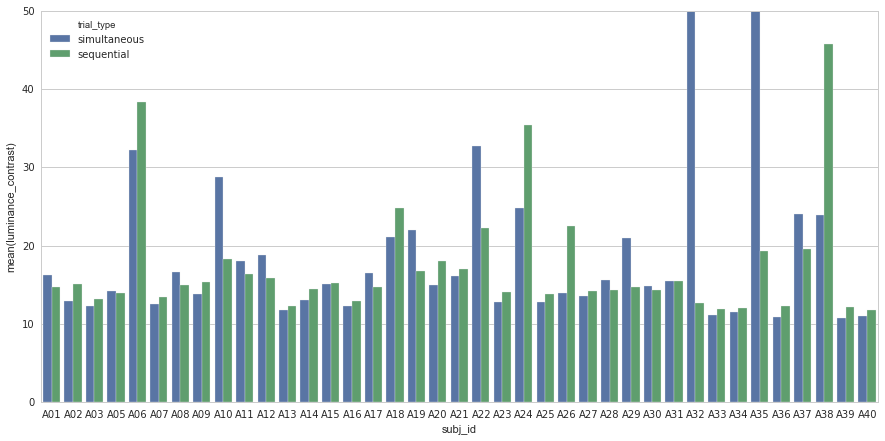

In [21]:
plt_sim = sns.barplot(x='subj_id', y='luminance_contrast'
                      , hue='trial_type'
                      , data=subjs_df)
plt_sim.set(ylim=(0,50))

In [22]:
subjs_df.pivot(index='subj_id', columns='trial_type', values='luminance_contrast')

trial_type,sequential,simultaneous
subj_id,,
A01,14.6415,16.2170
A02,15.0862,12.8744
A03,13.1210,12.2411
A05,13.9266,14.2473
A06,38.3467,32.2881
A07,13.3687,12.5596
A08,14.9927,16.5947
A09,15.3173,13.8374
A10,18.3419,28.8209
